In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

import numpy as np
from sklearn.preprocessing import StandardScaler

X = np.load("x_mlp_pred.npy")
y = np.load("y_mlp_pred.npy")
y2= np.load("y2_mlp_pred.npy")
y_treatment = np.load("treatments_y.npy")
y_grade = np.load("grade_y.npy")
clinical_data= np.load("clinic.npy")


print(X.shape[0])



data_min = X.min()
data_max = X.max()
X = (X - data_min) / (data_max - data_min)




from tensorflow.keras.utils import to_categorical
import numpy as np

# One-hot encoding
y_categorical = to_categorical(y, num_classes=3)
y2_categorical = to_categorical(y2, num_classes=5)
y_grade_categorical = to_categorical(y_grade , num_classes=4)
y_treatment_categorical = to_categorical(y_treatment , num_classes=12)




2025-05-27 13:45:19.357838: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 13:45:19.365011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748342719.373267 3772708 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748342719.375678 3772708 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748342719.382290 3772708 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

797


In [2]:
from sklearn.model_selection import train_test_split

# X: VGG16 çıktı tensorun (örneğin shape=(N, 2500, 512))
# clinical_data: klinik veriler (örneğin shape=(N, 28))
# y: etiketler (örneğin one-hot veya integer)

X_train, X_test, clinical_train, clinical_test, y_train, y_test,y2_train , y2_test , y_grade_train, y_grade_test , y_treatment_train , y_treatment_test = train_test_split(
    X, clinical_data, y_categorical,y2_categorical,y_grade_categorical,y_treatment_categorical,  # veya y integer label olabilir
    test_size=0.2,
    random_state=42,
    stratify=y_categorical  # stratify parametresi etiketlerin dağılımını korur
)

# 📊 Verilerin şekillerini yazdır
print("\n📦 Veri Bölme Sonuçları")
print("--------------------------------------------------")
print("📁 X (Görüntü Tabanlı Özellikler - VGG16 Çıktısı)")
print(f"  🔹 Eğitim: {X_train.shape}")
print(f"  🔹 Test  : {X_test.shape}")

print("\n🧬 Klinik Veriler")
print(f"  🔹 Eğitim: {clinical_train.shape}")
print(f"  🔹 Test  : {clinical_test.shape}")

print("\n🧠 Tanı Etiketleri (Primary Diagnosis - y)")
print(f"  🔹 Eğitim: {y_train.shape}")
print(f"  🔹 Test  : {y_test.shape}")

print("\n⏳ Yaşam Süresi Etiketleri (Survival Class - y2)")
print(f"  🔹 Eğitim: {y2_train.shape}")
print(f"  🔹 Test  : {y2_test.dtype}")
print(y2_train)
y2_train = y2_train.astype("float32")

print("\n🎓 Grade Etiketleri")
print(f"  🔹 Eğitim: {y_grade_train.shape}")
print(f"  🔹 Test  : {y_grade_test.shape}")

print("\n💉 Tedavi Türü Etiketleri")
print(f"  🔹 Eğitim: {y_treatment_train.shape}")
print(f"  🔹 Test  : {y_treatment_test.shape}")
print("--------------------------------------------------")

print("y2_train dtype:", y2_train.dtype)
print("y2_train example:", y2_train[:5])


📦 Veri Bölme Sonuçları
--------------------------------------------------
📁 X (Görüntü Tabanlı Özellikler - VGG16 Çıktısı)
  🔹 Eğitim: (637, 2500, 512)
  🔹 Test  : (160, 2500, 512)

🧬 Klinik Veriler
  🔹 Eğitim: (637, 5)
  🔹 Test  : (160, 5)

🧠 Tanı Etiketleri (Primary Diagnosis - y)
  🔹 Eğitim: (637, 3)
  🔹 Test  : (160, 3)

⏳ Yaşam Süresi Etiketleri (Survival Class - y2)
  🔹 Eğitim: (637, 5)
  🔹 Test  : float64
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]

🎓 Grade Etiketleri
  🔹 Eğitim: (637, 4)
  🔹 Test  : (160, 4)

💉 Tedavi Türü Etiketleri
  🔹 Eğitim: (637, 12)
  🔹 Test  : (160, 12)
--------------------------------------------------
y2_train dtype: float32
y2_train example: [[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [27]:


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Conv1D, GlobalAveragePooling1D, 
    LayerNormalization, TimeDistributed, Flatten, Concatenate
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
    BatchNormalization, Activation, Flatten, Concatenate, Add
)

from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, GlobalAveragePooling1D, Concatenate
)


#DENENDI SONUCLARI EZBERLEMEKTE IYI AMA VAL DUSUK KALIYOR
def simple_transformer_encoder(inputs, head_size=16, num_heads=1, ff_dim=32, dropout=0.3):
    # LayerNorm + MHA + Residual
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = Add()([inputs, Dropout(dropout)(attn_output)])  # (None, 2500, 512)

    # Feedforward
    x_ff = LayerNormalization(epsilon=1e-6)(x)
    x_ff = Dense(ff_dim, activation='relu')(x_ff)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(1)(x_ff)  # (None, 2500, 1)

    # Project residual to match shape
    residual = Dense(1)(x)
    x = Add()([residual, x_ff])  # (None, 2500, 1)

    return x


##BERBAT AMK
def simple_attention_block(inputs, head_size=32, num_heads=1, dropout=0.2):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    attn_output = Dropout(dropout)(attn_output)
    x = Add()([inputs, attn_output])
    return x

# 1D Conv katmanları - Lokal örüntüleri yakalamak için
def time_disturbed_cnn(image_input):
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(image_input)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)

    x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    
    return x

def time_disturbed_cnn_v2(image_input):
    x = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(1e-4))(image_input)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)

    x = Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    
    return x
#gr_accuracy: 0.6640 - gr_loss: 0.8203 - loss: 5.1267 - st_accuracy: 0.3961 - st_loss: 1.5228 - tr_accuracy: 0.2384 - tr_loss: 2.0805 - type_accuracy: 0.7187 - type_loss: 0.6745 - val_gr_accuracy: 0.5625 - val_gr_loss: 0.9807 - val_loss: 5.1708 - val_st_accuracy: 0.4922 - val_st_loss: 1.2972 - val_tr_accuracy: 0.2344 - val_tr_loss: 2.0480 - val_type_accuracy: 0.6875 - val_type_loss: 0.8161 - learning_rate: 1.2500e-05

def build_deep_2d_cnn(image_input, 
                      dropout_rate=0.3, l2_reg=1e-4):


    x = Conv2D(32, kernel_size=(3,3), padding='same', kernel_regularizer=l2(l2_reg))(image_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(64, kernel_size=(3,3), padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(128, kernel_size=(3,3), padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(256, kernel_size=(3,3), padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(dropout_rate)(x)

    x = GlobalAveragePooling2D()(x)
    
    return x

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)  # Residual connection + norm

    # Feed-forward network
    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x_ff = Dropout(dropout)(x_ff)
    x = LayerNormalization(epsilon=1e-6)(x + x_ff)  # Residual connection + norm
    return x



# Inputs
image_input = Input(shape=(2500, 512), name='image_input')
clinical_input = Input(shape=(5,), name='clinical_input')

# Transformer encoder bloğu (tek katman, daha basit)
x = simple_transformer_encoder(image_input, head_size=16, num_heads=1, ff_dim=32, dropout=0.3)


# Kullanımı
#x = simple_attention_block(image_input)

#x = time_disturbed_cnn_v2(image_input)

# Global pooling
#x = GlobalAveragePooling1D()(x)

#x = transformer_encoder(image_input)

#x = transformer_encoder(image_input, head_size=64, num_heads=8, ff_dim=256, dropout=0.1)
#x = transformer_encoder(x, head_size=64, num_heads=8, ff_dim=256, dropout=0.1)
#x = GlobalAveragePooling1D()(x)

# Basit fully connected katman
fc = Flatten()(x)
fc = Dense(32, activation='relu')(fc)
print(fc.shape)
# Klinik veriyi ekle
combined = Concatenate()([fc, clinical_input])

# Son katmanlar
fc2 = Dense(32, activation='relu')(combined)
fc2 = Dropout(0.4)(fc2)

output_type = Dense(3, activation='softmax', name='type')(fc2)
output_survival = Dense(5, activation='softmax', name='st')(fc2)
output_grade = Dense(4, activation='softmax', name='gr')(fc2)
output_treatment = Dense(12, activation='softmax', name='tr')(fc2)

# Model oluşturma
model = Model(inputs=[image_input, clinical_input], 
              outputs=[output_type, output_survival, output_grade, output_treatment])

# Modeli derleme
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss={
                  'type': 'categorical_crossentropy',
                  'st': 'categorical_crossentropy',
                  'gr': 'categorical_crossentropy',
                  'tr': 'categorical_crossentropy',
              },
              metrics={
                  'type': 'accuracy',
                  'st': 'accuracy',
                  'gr': 'accuracy',
                  'tr': 'accuracy',
              })

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()


(None, 32)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 2500, 512) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2500, 512) │      1,024 │ image_input[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2500, 512) │     33,328 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_66          │ (None, 2500, 512) │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_30 (Add)        │ (None, 2500, 512) │          0 │ image_input[0][0… │
│                     │                   │            │ dropout_66[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2500, 512) │      1,024 │ add_30[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 2500, 32)  │     16,416 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 2500, 32)  │          0 │ dense_48[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 2500, 1)   │        513 │ add_30[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 2500, 1)   │         33 │ dropout_67[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_31 (Add)        │ (None, 2500, 1)   │          0 │ dense_50[0][0],   │
│                     │                   │            │ dense_49[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 2500)      │          0 │ add_31[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 32)        │     80,032 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clinical_input      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 37)        │          0 │ dense_51[0][0],   │
│ (Concatenate)       │                   │            │ clinical_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 32)        │      1,216 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_68          │ (None, 32)        │          0 │ dense_52[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ type (Dense)        │ (None, 3)         │         99 │ dropout_68[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ st (Dense)          │ (None, 5)         │        165 │ dropout_68[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 134,378 (524.91 KB)

 Trainable params: 134,378 (524.91 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

#

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [29]:
history = model.fit(
    x={"image_input": X_train, "clinical_input": clinical_train},
    y={
        'st': y2_train,         # survival label (5 sınıf)
        'type': y_train,        # type label (3 sınıf)
        'gr': y_grade_train,    # grade label (4 sınıf)
        'tr': y_treatment_train # treatment label (12 sınıf)
    },
    epochs=100,
    batch_size=8,
    validation_split=0.2,
    callbacks=[lr ,es ]
   
)


Epoch 1/100


2025-05-27 14:22:04.119437: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20', 508 bytes spill stores, 508 bytes spill loads

2025-05-27 14:22:04.378526: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21', 28 bytes spill stores, 28 bytes spill loads

2025-05-27 14:22:04.738310: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21', 948 bytes spill stores, 948 bytes spill loads

2025-05-27 14:22:04.769484: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3901', 572 bytes spill stores, 572 bytes spill loads

2025-05-27 14:22:04.800541: I external/l

60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - gr_accuracy: 0.4836 - gr_loss: 1.3278 - loss: 8.0697 - st_accuracy: 0.2280 - st_loss: 2.0873 - tr_accuracy: 0.0930 - tr_loss: 3.2062 - type_accuracy: 0.4304 - type_loss: 1.4484

2025-05-27 14:22:10.558206: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40_0', 32 bytes spill stores, 32 bytes spill loads

2025-05-27 14:22:10.639392: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20', 4688 bytes spill stores, 4648 bytes spill loads

2025-05-27 14:22:10.758594: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3901', 28 bytes spill stores, 28 bytes spill loads

2025-05-27 14:22:11.007100: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 904 bytes spill stores, 904 bytes spill loads

2025-05-27 14:22:11.118968: I external

64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - gr_accuracy: 0.4853 - gr_loss: 1.3194 - loss: 7.9988 - st_accuracy: 0.2281 - st_loss: 2.0721 - tr_accuracy: 0.0937 - tr_loss: 3.1743 - type_accuracy: 0.4293 - type_loss: 1.4329 - val_gr_accuracy: 0.4375 - val_gr_loss: 1.2266 - val_loss: 6.2692 - val_st_accuracy: 0.2031 - val_st_loss: 1.5962 - val_tr_accuracy: 0.1797 - val_tr_loss: 2.3985 - val_type_accuracy: 0.4297 - val_type_loss: 1.0479 - learning_rate: 1.0000e-04
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - gr_accuracy: 0.5259 - gr_loss: 1.1149 - loss: 6.2762 - st_accuracy: 0.2105 - st_loss: 1.6892 - tr_accuracy: 0.1424 - tr_loss: 2.4402 - type_accuracy: 0.4785 - type_loss: 1.0319 - val_gr_accuracy: 0.5547 - val_gr_loss: 1.1271 - val_loss: 6.0558 - val_st_accuracy: 0.1875 - val_st_loss: 1.6142 - val_tr_accuracy: 0.2656 - val_tr_loss: 2.3566 - val_type_accuracy: 0.6094 - val_type_loss: 0.9579 - learning_rate: 1.0000e-04
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - gr_accur

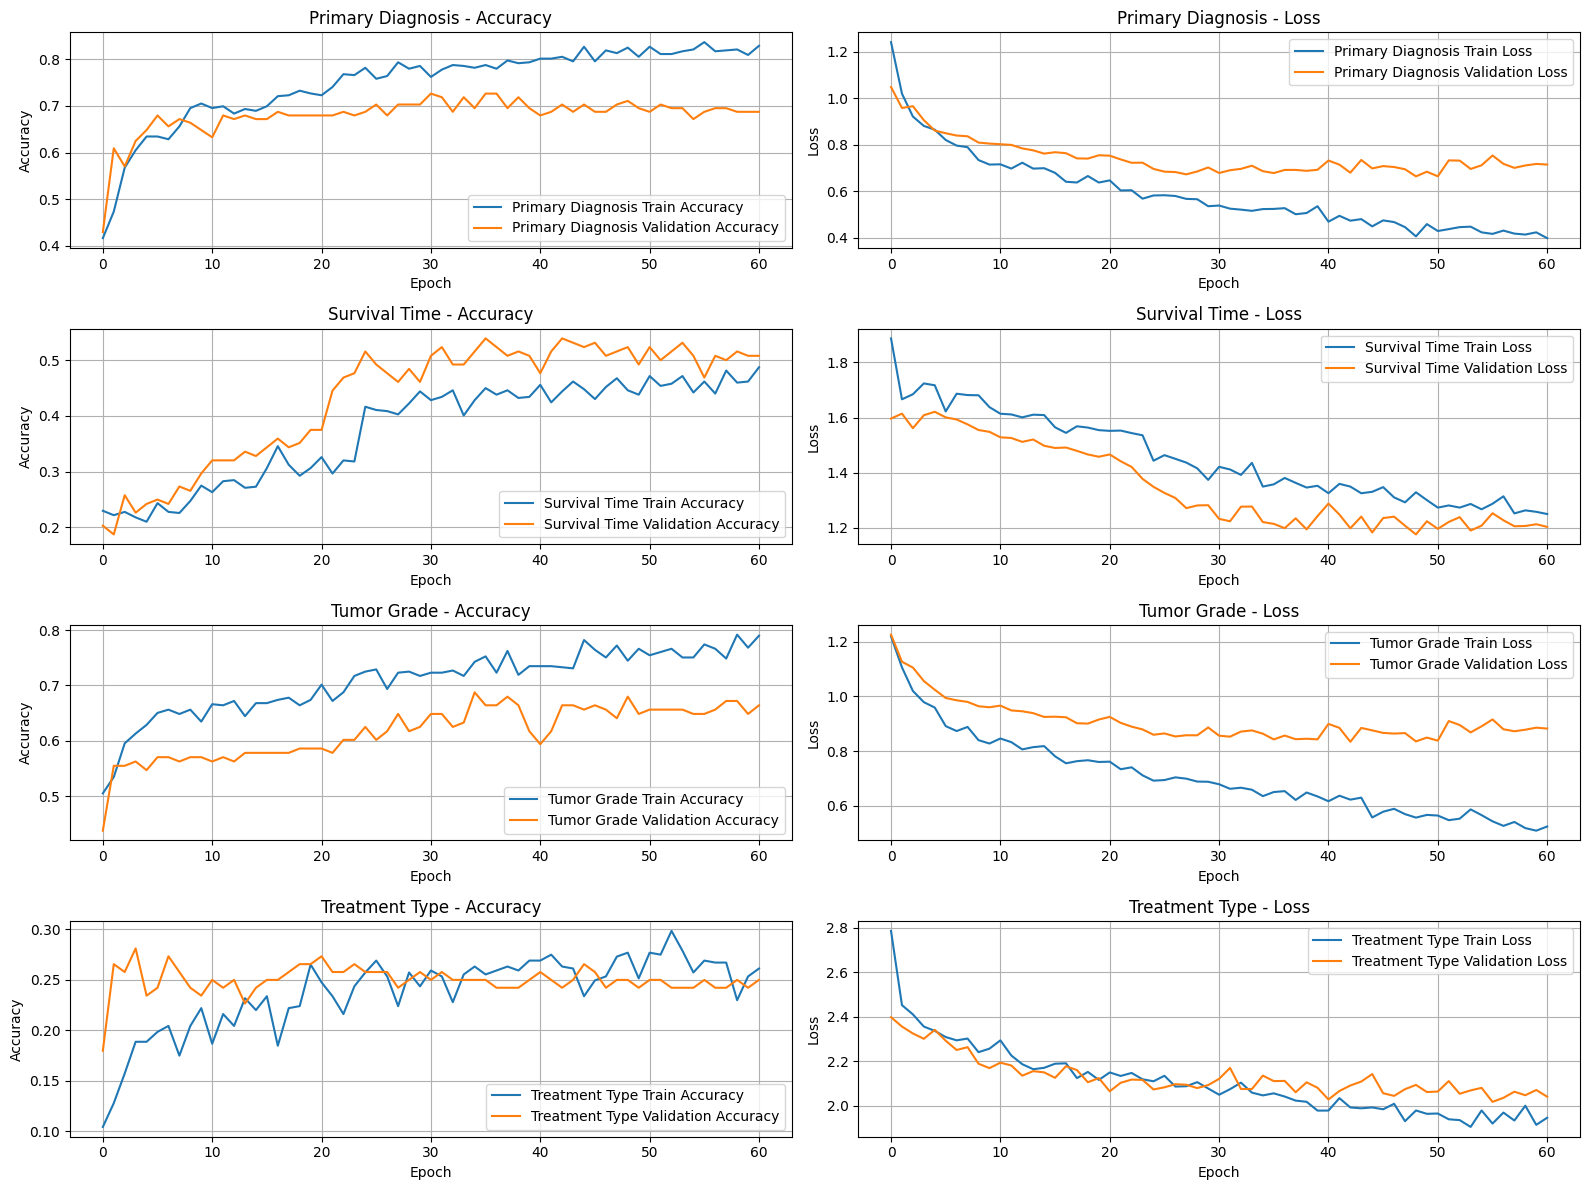

In [30]:
import matplotlib.pyplot as plt

output_names = {
    'type': 'Primary Diagnosis',
    'st': 'Survival Time',
    'gr': 'Tumor Grade',
    'tr': 'Treatment Type'
}

metrics = ['accuracy', 'loss']

plt.figure(figsize=(16, 12))

plot_idx = 1

for output_key, output_title in output_names.items():
    for metric in metrics:
        train_key = f"{output_key}_{metric}"
        val_key = f"val_{output_key}_{metric}"
        
        plt.subplot(len(output_names), 2, plot_idx)
        plt.plot(history.history[train_key], label=f'{output_title} Train {metric.capitalize()}')
        plt.plot(history.history[val_key], label=f'{output_title} Validation {metric.capitalize()}')
        plt.title(f'{output_title} - {metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plot_idx += 1

plt.tight_layout()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


<Figure size 800x800 with 0 Axes>

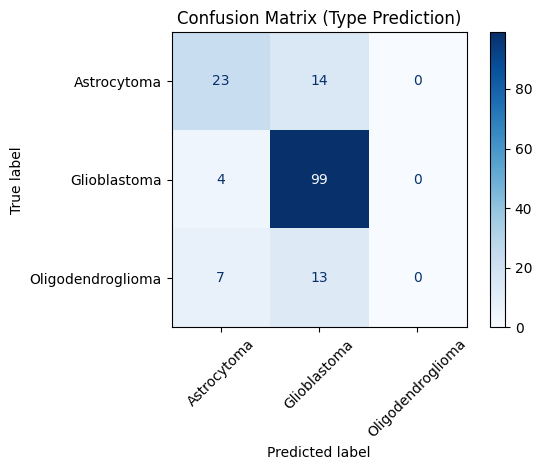

<Figure size 800x800 with 0 Axes>

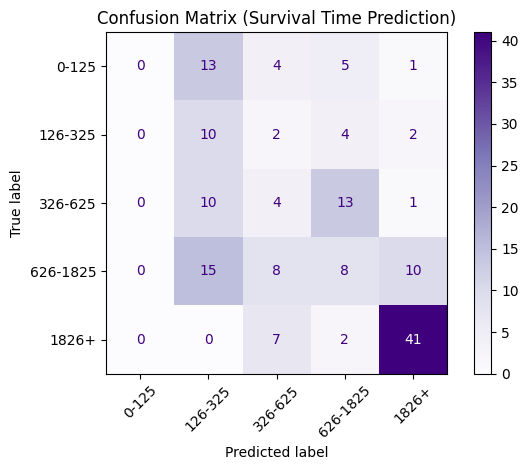

<Figure size 800x800 with 0 Axes>

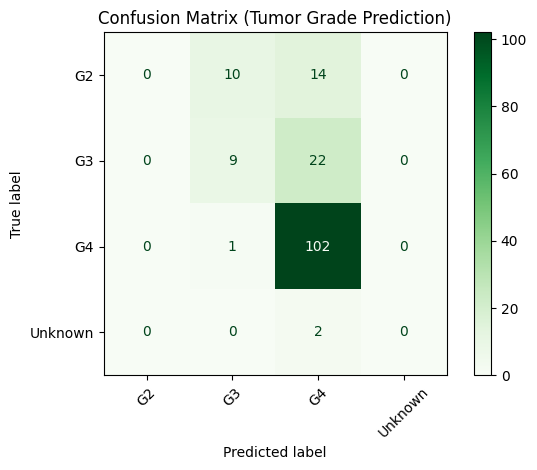

<Figure size 800x800 with 0 Axes>

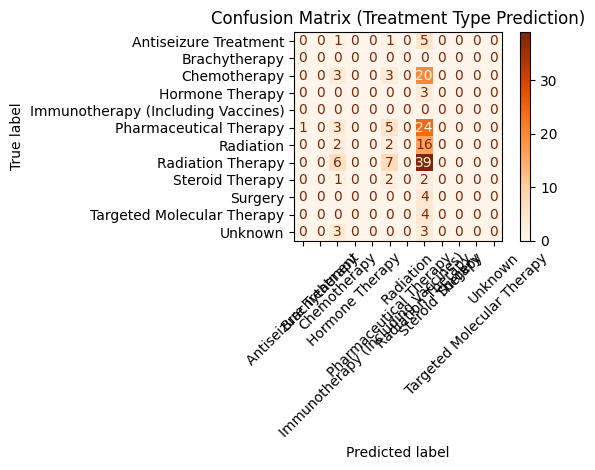

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Model tahminleri
y_pred_proba = model.predict([X_test, clinical_test])

# Argmax ile tahmin sınıf indekslerini al
y_pred_type = np.argmax(y_pred_proba[0], axis=1)
y_pred_survival = np.argmax(y_pred_proba[1], axis=1)
y_pred_grade = np.argmax(y_pred_proba[2], axis=1)
y_pred_treatment = np.argmax(y_pred_proba[3], axis=1)

# Gerçek etiketleri argmax ile al
y_true_type = np.argmax(y_test, axis=1)
y_true_survival = np.argmax(y2_test, axis=1)
y_true_grade = np.argmax(y_grade_test, axis=1)
y_true_treatment = np.argmax(y_treatment_test, axis=1)

# Etiket isimleri (senin verdiğin sınıflar)
label_names_type = ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']
label_names_survival = ['0-125', '126-325', '326-625', '626-1825', '1826+']
label_names_grade = ['G2', 'G3', 'G4', 'Unknown']
label_names_treatment = [
    'Antiseizure Treatment',
    'Brachytherapy',
    'Chemotherapy',
    'Hormone Therapy',
    'Immunotherapy (Including Vaccines)',
    'Pharmaceutical Therapy',
    'Radiation',
    'Radiation Therapy',
    'Steroid Therapy',
    'Surgery',
    'Targeted Molecular Therapy',
    'Unknown'
]

# Confusion matrix çizim fonksiyonu
def plot_cm(y_true, y_pred, labels, title, cmap='Blues'):
    n_labels = len(labels)
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_labels))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=(8, 8))
    disp.plot(cmap=cmap, values_format='d')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Confusion Matrix’leri çiz
plot_cm(y_true_type, y_pred_type, label_names_type, "Confusion Matrix (Type Prediction)", cmap='Blues')
plot_cm(y_true_survival, y_pred_survival, label_names_survival, "Confusion Matrix (Survival Time Prediction)", cmap='Purples')
plot_cm(y_true_grade, y_pred_grade, label_names_grade, "Confusion Matrix (Tumor Grade Prediction)", cmap='Greens')
plot_cm(y_true_treatment, y_pred_treatment, label_names_treatment, "Confusion Matrix (Treatment Type Prediction)", cmap='Oranges')
